In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from poles_roots.aaa import AAA
from poles_roots._utils import linspace_on_tri, convert_cart_to_complex
from tqdm import tqdm
plt.style.use("/home/jakeb/development/poles-and-roots/notebooks/science.mplstyle")

For now we only consider right triangle of different sizes.

In [2]:
side_lengths = [1, 25]

def linspace_on_tri(points, num):
    points = np.vstack([points, points[0, :]])
    ds = np.linalg.norm(np.diff(points, axis=0), axis=1)
    s = np.cumsum(np.append(0, ds))
    b = scipy.interpolate.make_interp_spline(s, points, k=1)
    return b(np.linspace(0, s[-1], num=num, endpoint=False))

def linspace_in_square(num, side_length):
    tmp = np.linspace(0, side_length, num=num)
    [xx, yy] = np.meshgrid(tmp, tmp)
    return xx.ravel(), yy.ravel()

# First for a meromorphic function

\begin{equation}
f(z) = \frac{1}{(z - a)^\alpha},
\end{equation}
where $a$ is drawn from uniform distribution and $\alpha$ is a random integer drawn from $\{1,2,\dots,9\}$.

In [3]:
rng = np.random.default_rng(123456)
in_pole_error = []
on_pole_error = []
order = 1

for side_length in side_lengths:
    points = np.array([[0,0], [side_length, 0], [side_length, side_length], [0, side_length]])
    in_pole_error_tmp = []
    on_pole_error_tmp = []
    for _ in tqdm(range(1000)):
        # generate random pole
        re_pole = rng.uniform(0, side_length)
        im_pole = rng.uniform(0, side_length)
        
        pole = re_pole+im_pole*1j
        def f(z):
            return 1/(z-(pole))**order
        
        x, y = linspace_in_square(10, side_length)
        Z_in = x+y*1j
        F_in = f(Z_in)
        
        n_actual = x.size
        
        Z = convert_cart_to_complex(linspace_on_tri(points, n_actual))
        F = f(Z)
        
        res_in = AAA(F_in, Z_in)
        res = AAA(F, Z)
        
        in_pole_error_tmp.append(np.min(np.abs(res_in.poles - pole)))
        on_pole_error_tmp.append(np.min(np.abs(res.poles - pole)))
    in_pole_error.append(in_pole_error_tmp)
    on_pole_error.append(on_pole_error_tmp)
        

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1354.47it/s]


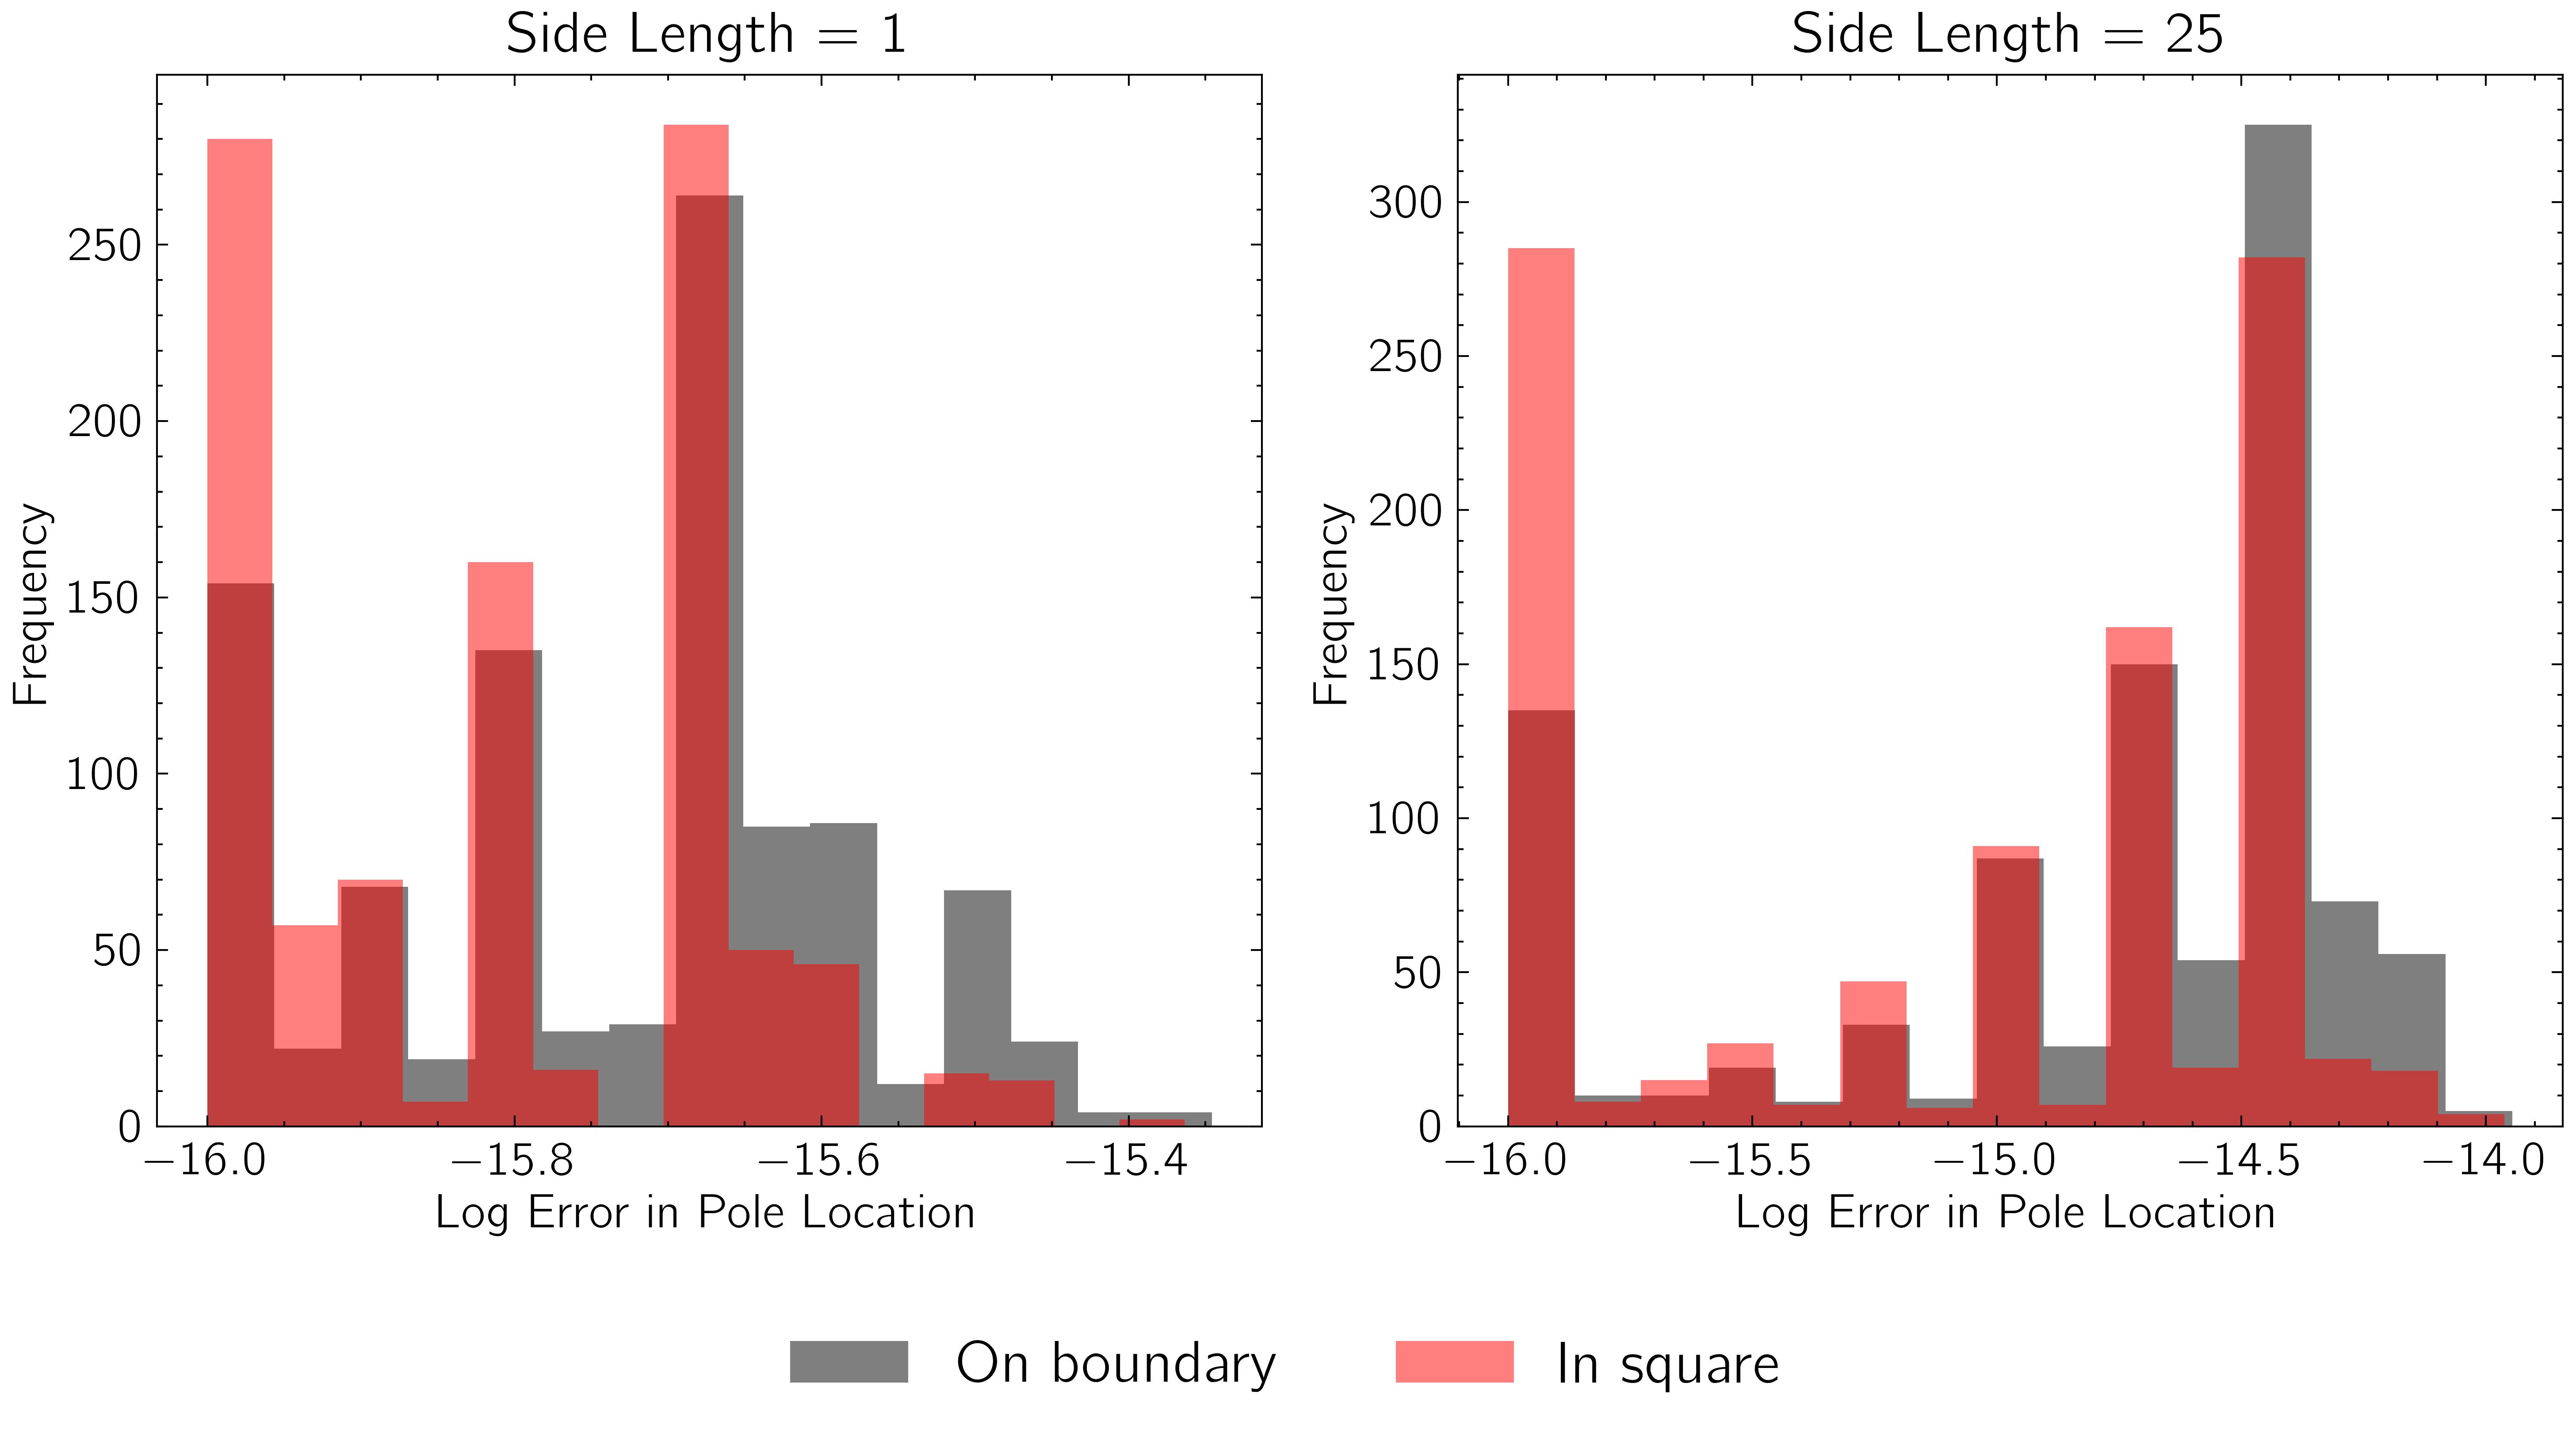

In [4]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
for i in range(2):
    ax = axs[i]
    ax.hist(np.log10(np.asarray(on_pole_error[i]) + 1e-16), alpha=0.5, label="On boundary", bins=15)
    ax.hist(np.log10(np.asarray(in_pole_error[i]) + 1e-16), alpha=0.5, label="In square", bins=15)
    ax.set_xlabel("Log Error in Pole Location")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Side Length = {side_lengths[i]}")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0),
           fancybox=True, shadow=True, ncol=4, fontsize=16)
plt.tight_layout()
plt.savefig("figures/AAA_sampling.pdf")

# Then for a Holomorphic function

\begin{equation}
f(z) = (z - a)^\alpha,
\end{equation}
where $a$ is drawn from uniform distribution and $\alpha$ is a random integer drawn from $\{1,2,\dots,9\}$.

In [7]:
rng = np.random.default_rng(123456)
in_iterations = []
on_iterations = []
in_pole_error = []
on_pole_error = []
in_approximation_error = []
on_approximation_error = []
orders = [1, 2, 4, 8]

for order in orders:
    in_iterations_tmp = []
    on_iterations_tmp = []
    in_pole_error_tmp = []
    on_pole_error_tmp = []
    in_approximation_error_tmp = []
    on_approximation_error_tmp = []
    for _ in tqdm(range(1000)):
        # generate random zero
        re_pole = rng.uniform(0, side_length)
        im_pole = rng.uniform(0, side_length)
        if re_pole + im_pole > side_length:
            re_pole = side_length - re_pole
            im_pole = side_length - im_pole   
        
        zero = re_pole+im_pole*1j
        def f(z):
            return (z-(zero))**order
        
        x, y = linspace_in_right_triangle(1000, side_length)
        Z_in = x+y*1j
        F_in = f(Z_in)
        
        n_actual = x.size
        
        Z = convert_cart_to_complex(linspace_on_tri(points, n_actual))
        F = f(Z)
        
        res_in = AAA(F_in, Z_in)
        res = AAA(F, Z)
        
        on_iterations_tmp.append(res.weights.size)
        in_iterations_tmp.append(res_in.weights.size)
        in_pole_error_tmp.append(np.min(np.abs(res_in.roots - zero)))
        on_pole_error_tmp.append(np.min(np.abs(res.roots - zero)))
        
        # generate random points to sample the approximation at
        re_sample = rng.uniform(0, side_length, size=10)
        im_sample = rng.uniform(0, side_length, size=10)
        mask = re_sample + im_sample > side_length
        re_sample[mask] = side_length - re_sample[mask]
        im_sample[mask] = side_length - im_sample[mask]
        sample = re_sample + im_sample*1j
        
        in_approximation_error_tmp.append(np.max(np.abs(f(sample) - res_in(sample))))
        on_approximation_error_tmp.append(np.max(np.abs(f(sample) - res(sample))))
    in_iterations.append(in_iterations_tmp)
    on_iterations.append(on_iterations_tmp)
    in_pole_error.append(in_pole_error_tmp)
    on_pole_error.append(on_pole_error_tmp)
    in_approximation_error.append(in_approximation_error_tmp)
    on_approximation_error.append(on_approximation_error_tmp)

100%|██████████| 1000/1000 [01:12<00:00, 13.77it/s]


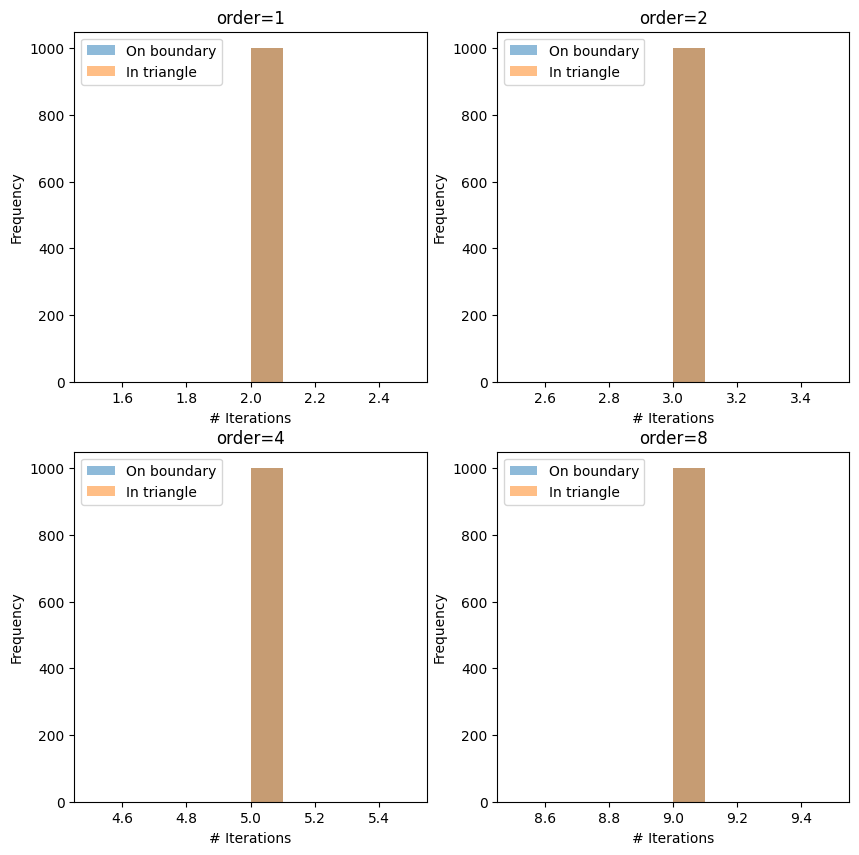

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, (ax, order) in enumerate(zip(axs.ravel(), orders)):
    ax.hist(on_iterations[i], alpha=0.5, label="On boundary")
    ax.hist(in_iterations[i], alpha=0.5, label="In triangle")
    ax.set_xlabel("# Iterations")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{order=}")
    ax.legend()

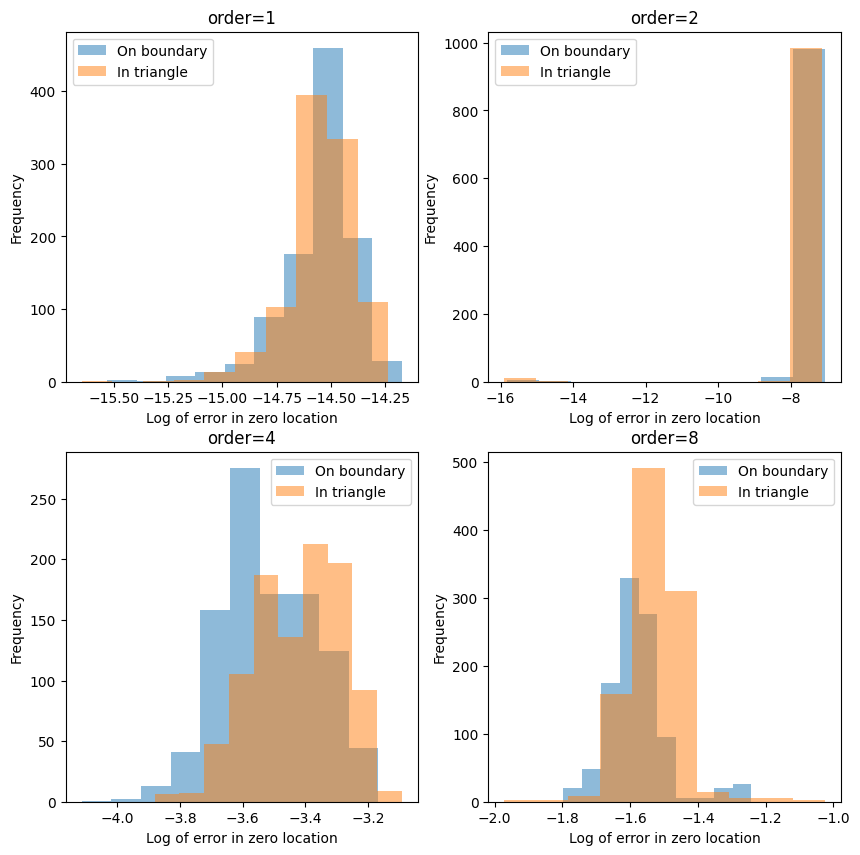

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, (ax, order) in enumerate(zip(axs.ravel(), orders)):
    ax.hist(np.log10(np.asarray(on_pole_error[i]) + 1e-16), alpha=0.5, label="On boundary")
    ax.hist(np.log10(np.asarray(in_pole_error[i]) + 1e-16), alpha=0.5, label="In triangle")
    ax.set_xlabel("Log of error in zero location")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{order=}")
    ax.legend()

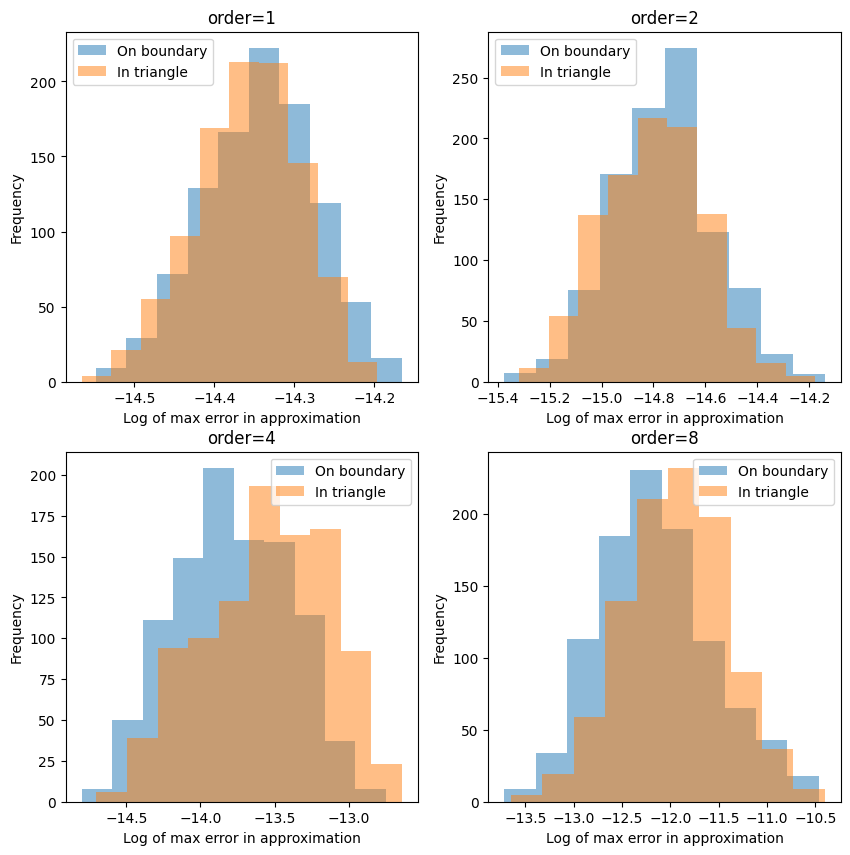

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, (ax, order) in enumerate(zip(axs.ravel(), orders)):
    ax.hist(np.log10(on_approximation_error[i]), alpha=0.5, label="On boundary")
    ax.hist(np.log10(in_approximation_error[i]), alpha=0.5, label="In triangle")
    ax.set_xlabel("Log of max error in approximation")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{order=}")
    ax.legend()